# 🚌 Bus Demand Forecasting with Spatio-Temporal GNN & Tree-Based Models  
> _A powerful hybrid approach to optimize urban mobility_

---

## 📋 Overview

This pipeline covers the complete journey of a bus demand prediction task, blending graph neural networks and tree-based models. From raw data exploration to model validation and final prediction!

---

## 🔍 What You'll Find Inside

### 📦 1. Data Loading & Exploratory Analysis  
Load the datasets and perform preliminary data inspection to understand trends, outliers, and temporal patterns.

### 🛠️ 2. Feature Engineering with Holiday Awareness  
Engineer relevant features for both train and test sets, including holiday flags using the `python-holidays` package. 🎉

### 🧭 3. Route Graph Construction  
Construct a spatial route graph based on bus stop data to feed into the GNN model.

### 🧠 4. GNN Model Training with Early Stopping  
Define and train a Spatio-Temporal Graph Neural Network, leveraging early stopping on validation RMSE to prevent overfitting. 🛑

### 🌲 5. Tree-Based Model Ensemble  
Train and evaluate multiple tree-based algorithms on the tabular features:
- XGBoost 🌟  
- LightGBM ⚡  
- CatBoost 🐱  
- Random Forest 🌳

Validation RMSE is used to determine the top-performing model.

### 📤 6. Prediction & Submission  
Generate predictions on the test set using the best model and format results into a ready-to-submit file. ✅

---

## 📁 Output  
A tidy `.csv` file perfect for this Competition.

---

Crafted for precision and scalability—this project is your ticket to mastering multi-model demand forecasting. 🚀


# The Pipeline

## Initial Setup

In [1]:
!pip install torch-geometric catboost category-encoders optuna -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.7/242.7 kB 18.2 MB/s eta 0:00:00


In [35]:
# Ignore any unnecessary Warnings
import warnings
warnings.filterwarnings('ignore')

#---------------------------------

# Ensure Consistent behaviour
import os
import random
import numpy as np
import torch

def set_random_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)

set_random_seed()

#---------------------------------

# Global-Variable(s)
PI_VAL = np.pi

## Data Loading & Exploratory Analysis

In [36]:
import pandas as pd

train_df = pd.read_csv('/content/train/train.csv', parse_dates=['doj'])
trans = pd.read_csv('/content/train/transactions.csv', parse_dates=['doj', 'doi'])
test_df = pd.read_csv('/content/test_8gqdJqH.csv', parse_dates=['doj'])

train_df.shape, trans.shape, test_df.shape

((67200, 4), (2266100, 11), (5900, 4))

In [ ]:
train_df

,doj,srcid,destid,final_seatcount
0,2023-03-01,45,46,2838.0
1,2023-03-01,46,45,2298.0
2,2023-03-01,45,47,2720.0
3,2023-03-01,47,45,2580.0
4,2023-03-01,46,9,4185.0
...,...,...,...,...
67195,2024-12-31,2,24,800.0
67196,2024-12-31,44,45,1360.0
67197,2024-12-31,47,10,560.0
67198,2024-12-31,38,36,535.0


from matplotlib import pyplot as plt
train_df['srcid'].plot(kind='hist', bins=20, title='srcid')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
train_df['destid'].plot(kind='hist', bins=20, title='destid')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
train_df['final_seatcount'].plot(kind='hist', bins=20, title='final_seatcount')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
train_df.plot(kind='scatter', x='srcid', y='destid', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
train_df.plot(kind='scatter', x='destid', y='final_seatcount', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['doj']
  ys = series['srcid']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = train_df.sort_values('doj', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('doj')
_ = plt.ylabel('srcid')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['doj']
  ys = series['destid']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = train_df.sort_values('doj', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('doj')
_ = plt.ylabel('destid')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['doj']
  ys = series['final_seatcount']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = train_df.sort_values('doj', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('doj')
_ = plt.ylabel('final_seatcount')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['doj']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'doj'}, axis=1)
              .sort_values('doj', ascending=True))
  xs = counted['doj']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = train_df.sort_values('doj', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('doj')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
train_df['srcid'].plot(kind='line', figsize=(8, 4), title='srcid')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
train_df['destid'].plot(kind='line', figsize=(8, 4), title='destid')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
train_df['final_seatcount'].plot(kind='line', figsize=(8, 4), title='final_seatcount')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
trans

,doj,doi,srcid,destid,srcid_region,destid_region,srcid_tier,destid_tier,cumsum_seatcount,cumsum_searchcount,dbd
0,2023-03-01,2023-01-30,45,46,Karnataka,Tamil Nadu,Tier 1,Tier 1,8.0,76.0,30
1,2023-03-01,2023-01-30,46,45,Tamil Nadu,Karnataka,Tier 1,Tier 1,8.0,70.0,30
2,2023-03-01,2023-01-30,45,47,Karnataka,Andhra Pradesh,Tier 1,Tier 1,4.0,142.0,30
3,2023-03-01,2023-01-30,47,45,Andhra Pradesh,Karnataka,Tier 1,Tier 1,0.0,68.0,30
4,2023-03-01,2023-01-30,46,9,Tamil Nadu,Tamil Nadu,Tier 1,Tier2,9.0,162.0,30
...,...,...,...,...,...,...,...,...,...,...,...
2266095,2025-02-28,2025-02-28,2,24,Maharashtra and Goa,Maharashtra and Goa,Tier 1,Tier2,0.0,0.0,0
2266096,2025-02-28,2025-02-28,44,45,Tamil Nadu,Karnataka,Tier2,Tier 1,0.0,0.0,0
2266097,2025-02-28,2025-02-28,47,10,Andhra Pradesh,Andhra Pradesh,Tier 1,Tier 3,0.0,0.0,0
2266098,2025-02-28,2025-02-28,38,36,Rest of North,Delhi,Tier 1,Tier2,0.0,0.0,0


from matplotlib import pyplot as plt
trans['srcid'].plot(kind='hist', bins=20, title='srcid')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
trans['destid'].plot(kind='hist', bins=20, title='destid')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
trans['cumsum_seatcount'].plot(kind='hist', bins=20, title='cumsum_seatcount')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
trans['cumsum_searchcount'].plot(kind='hist', bins=20, title='cumsum_searchcount')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
trans.groupby('srcid_tier').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
trans.groupby('destid_tier').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
trans.plot(kind='scatter', x='srcid', y='destid', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
trans.plot(kind='scatter', x='destid', y='cumsum_seatcount', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
trans.plot(kind='scatter', x='cumsum_seatcount', y='cumsum_searchcount', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
trans.plot(kind='scatter', x='cumsum_searchcount', y='dbd', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['doj']
  ys = series['srcid']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = trans.sort_values('doj', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('srcid_tier')):
  _plot_series(series, series_name, i)
  fig.legend(title='srcid_tier', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('doj')
_ = plt.ylabel('srcid')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['doj']
  ys = series['srcid']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = trans.sort_values('doj', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('destid_tier')):
  _plot_series(series, series_name, i)
  fig.legend(title='destid_tier', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('doj')
_ = plt.ylabel('srcid')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['doj']
  ys = series['destid']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = trans.sort_values('doj', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('srcid_tier')):
  _plot_series(series, series_name, i)
  fig.legend(title='srcid_tier', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('doj')
_ = plt.ylabel('destid')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['doj']
  ys = series['destid']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = trans.sort_values('doj', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('destid_tier')):
  _plot_series(series, series_name, i)
  fig.legend(title='destid_tier', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('doj')
_ = plt.ylabel('destid')

from matplotlib import pyplot as plt
trans['srcid'].plot(kind='line', figsize=(8, 4), title='srcid')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
trans['destid'].plot(kind='line', figsize=(8, 4), title='destid')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
trans['cumsum_seatcount'].plot(kind='line', figsize=(8, 4), title='cumsum_seatcount')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
trans['cumsum_searchcount'].plot(kind='line', figsize=(8, 4), title='cumsum_searchcount')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['destid_tier'].value_counts()
    for x_label, grp in trans.groupby('srcid_tier')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('srcid_tier')
_ = plt.ylabel('destid_tier')

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(trans['srcid_tier'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(trans, x='srcid', y='srcid_tier', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(trans['destid_tier'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(trans, x='srcid', y='destid_tier', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(trans['srcid_tier'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(trans, x='destid', y='srcid_tier', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(trans['destid_tier'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(trans, x='destid', y='destid_tier', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

ERROR:root:Did not find quickchart key chart-7ea9ef02-f762-4da6-881f-344777b4b84f in chart cache


In [ ]:
test_df

,route_key,doj,srcid,destid
0,2025-02-11_46_45,2025-02-11,46,45
1,2025-01-20_17_23,2025-01-20,17,23
2,2025-01-08_02_14,2025-01-08,2,14
3,2025-01-08_08_47,2025-01-08,8,47
4,2025-01-08_09_46,2025-01-08,9,46
...,...,...,...,...
5895,2025-01-23_46_48,2025-01-23,46,48
5896,2025-02-21_46_09,2025-02-21,46,9
5897,2025-01-17_32_19,2025-01-17,32,19
5898,2025-01-24_45_03,2025-01-24,45,3


In [ ]:
train_df.isna().sum()

,0
doj,0
srcid,0
destid,0
final_seatcount,0


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67200 entries, 0 to 67199
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   doj              67200 non-null  datetime64[ns]
 1   srcid            67200 non-null  int64         
 2   destid           67200 non-null  int64         
 3   final_seatcount  67200 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 2.1 MB


In [ ]:
trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2266100 entries, 0 to 2266099
Data columns (total 11 columns):
 #   Column              Dtype         
---  ------              -----         
 0   doj                 datetime64[ns]
 1   doi                 datetime64[ns]
 2   srcid               int64         
 3   destid              int64         
 4   srcid_region        object        
 5   destid_region       object        
 6   srcid_tier          object        
 7   destid_tier         object        
 8   cumsum_seatcount    float64       
 9   cumsum_searchcount  float64       
 10  dbd                 int64         
dtypes: datetime64[ns](2), float64(2), int64(3), object(4)
memory usage: 190.2+ MB


In [ ]:
train_df.describe().T

,count,mean,min,25%,50%,75%,max,std
doj,67200,2024-01-30 11:59:59.999999744,2023-03-01 00:00:00,2023-08-15 18:00:00,2024-01-30 12:00:00,2024-07-16 06:00:00,2024-12-31 00:00:00,NaN
srcid,67200.0,29.55,1.0,14.75,36.0,45.0,48.0,16.670082
destid,67200.0,29.75,1.0,15.75,34.5,45.0,48.0,15.938986
final_seatcount,67200.0,2001.729464,2.0,1252.0,1685.0,2408.0,13503.0,1194.71114


In [37]:
df = train_df.copy()
print(df.shape)
df = df.drop_duplicates()
print(df.shape)

(67200, 4)
(67200, 4)


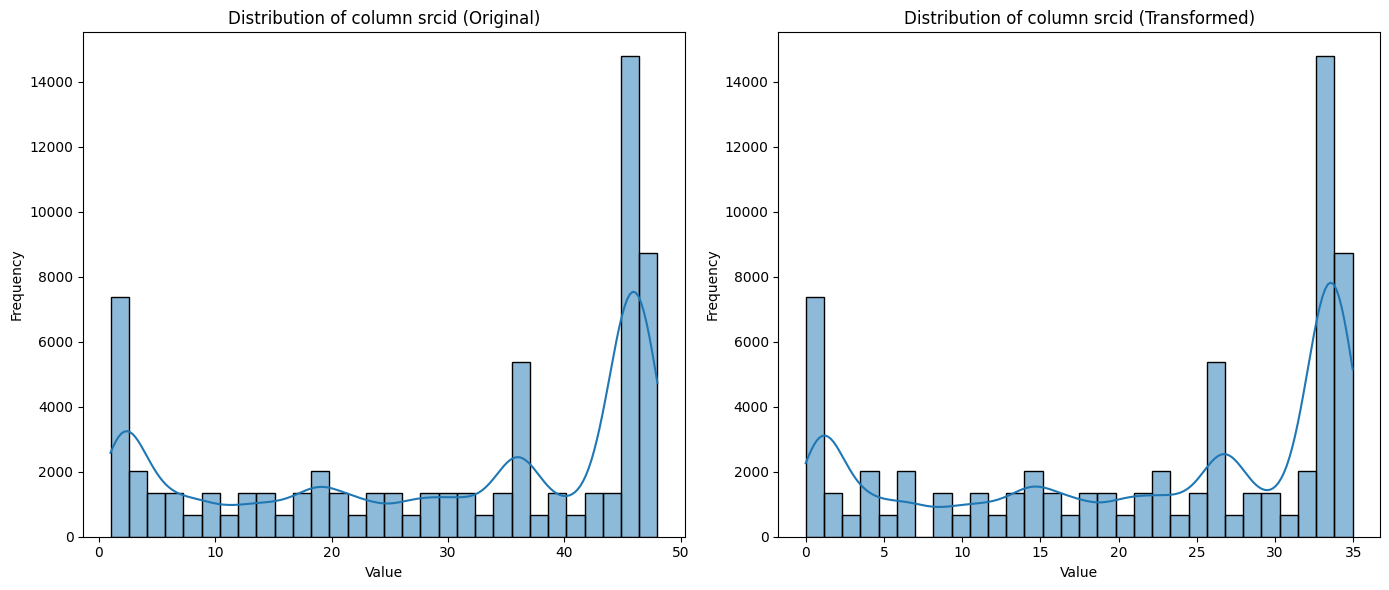

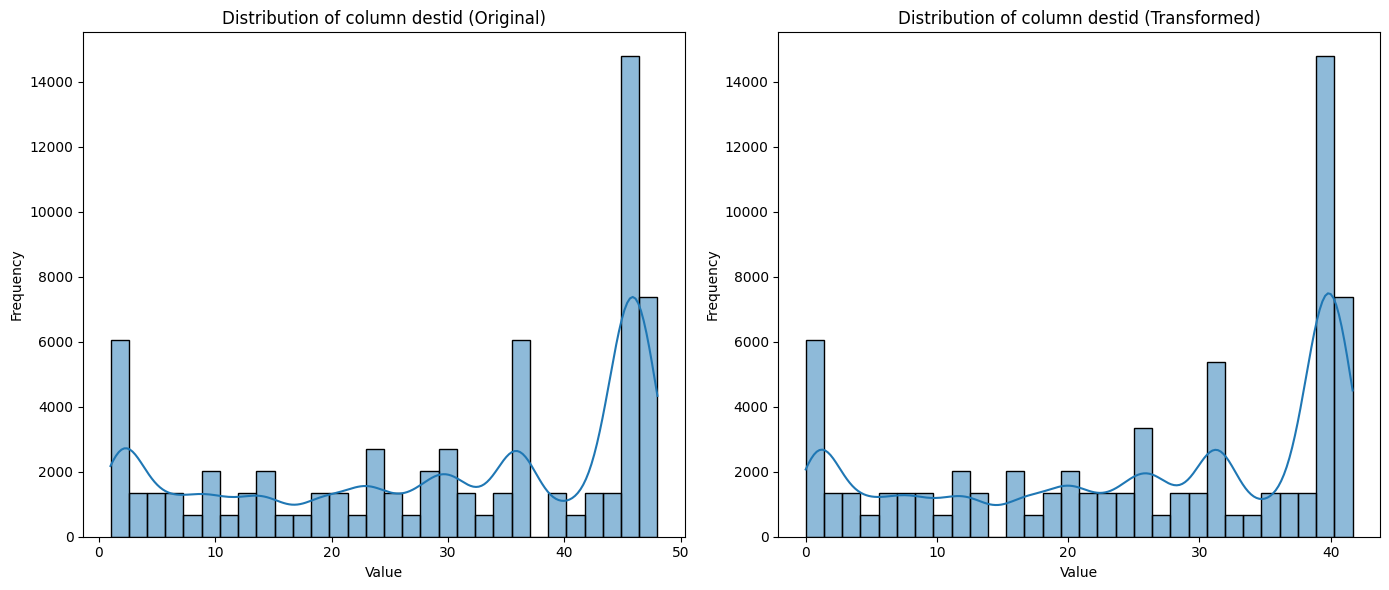

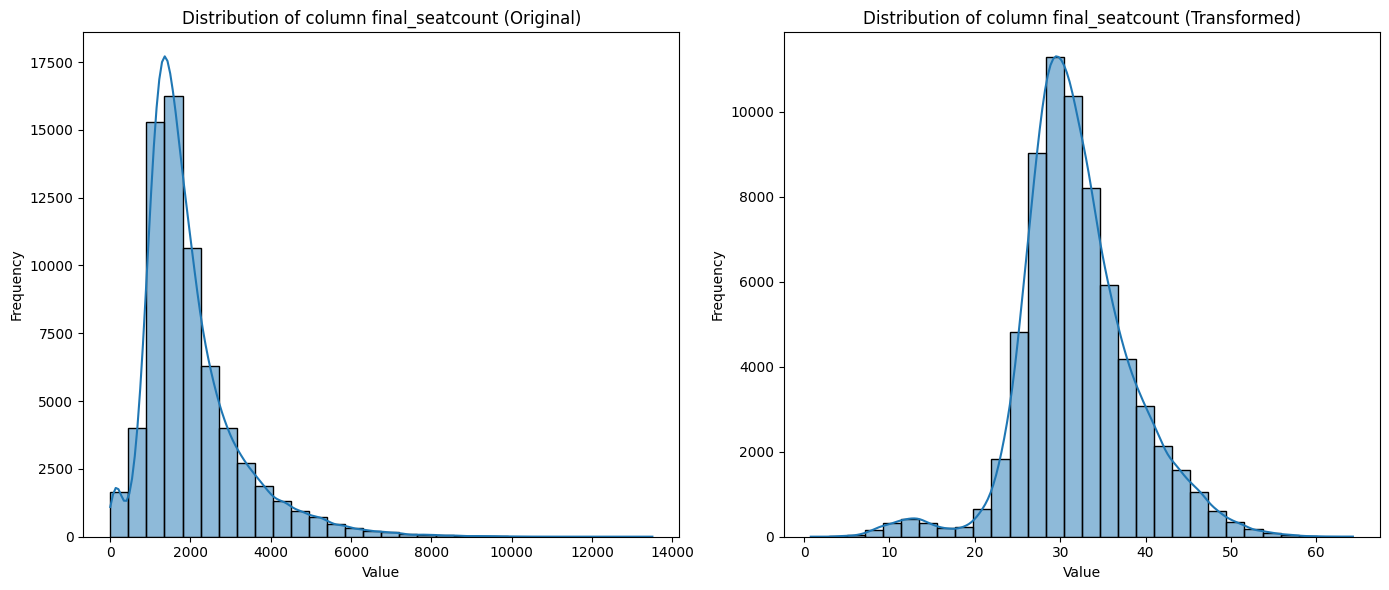

In [6]:
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

num_cols = ['srcid', 'destid', 'final_seatcount']
df = train_df[num_cols].copy()

# Transformation
for col in num_cols:
    # Define a new column name for the transformed data
    transformed_col = col + '_transformed'

    # Box-Cox transformation
    df[transformed_col], _ = stats.boxcox(df[col])

    # Plotting the distributions
    plt.figure(figsize=(14, 6))

    # Original distribution
    plt.subplot(1, 2, 1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of column {col} (Original)')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

    # Transformed distribution
    plt.subplot(1, 2, 2)
    sns.histplot(df[transformed_col], kde=True, bins=30)
    plt.title(f'Distribution of column {col} (Transformed)')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()

In [7]:
df = train_df[num_cols].copy()

def detect_outliers_iqr(dataframe):
    outlier_info = {}
    for col in dataframe.columns:
        # Compute the first (Q1) and third quartiles (Q3)
        Q1, Q3 = dataframe[col].quantile([0.25, 0.75])
        IQR = Q3 - Q1

        # Define the outlier limits
        lb, ub = Q1 - (1.5 * IQR), Q3 + (1.5 * IQR)

        # Identify outliers: values below lower_bound or above upper_bound.
        mask = (dataframe[col] < lb) | (dataframe[col] > ub)
        outliers = dataframe[mask][col].tolist()

        # Save the details for the column
        outlier_info[col] = {
            'Q1': Q1, 'Q3': Q3, 'IQR': IQR,
            'lower_bound': lb, 'upper_bound': ub, 'outliers': outliers
            }
    return outlier_info

# Detect outliers and capture the details for each column.
results = detect_outliers_iqr(df)

# Display the findings
for col, info in results.items():
    print(f"Column: {col}")
    print(f"Number of Outliers:   {len(info['outliers'])}\n")

Column: srcid
Number of Outliers:   0

Column: destid
Number of Outliers:   0

Column: final_seatcount
Number of Outliers:   4141



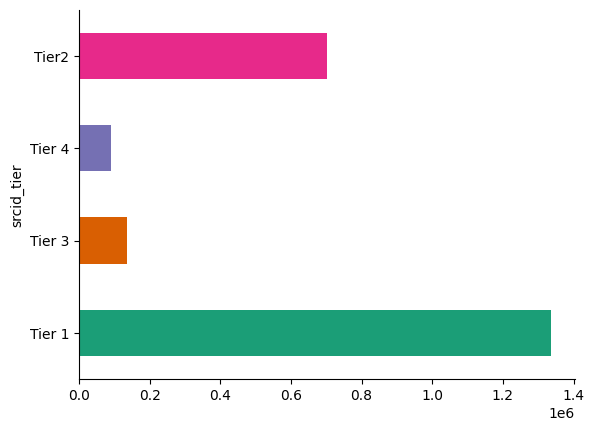

In [ ]:
trans.groupby('srcid_tier').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

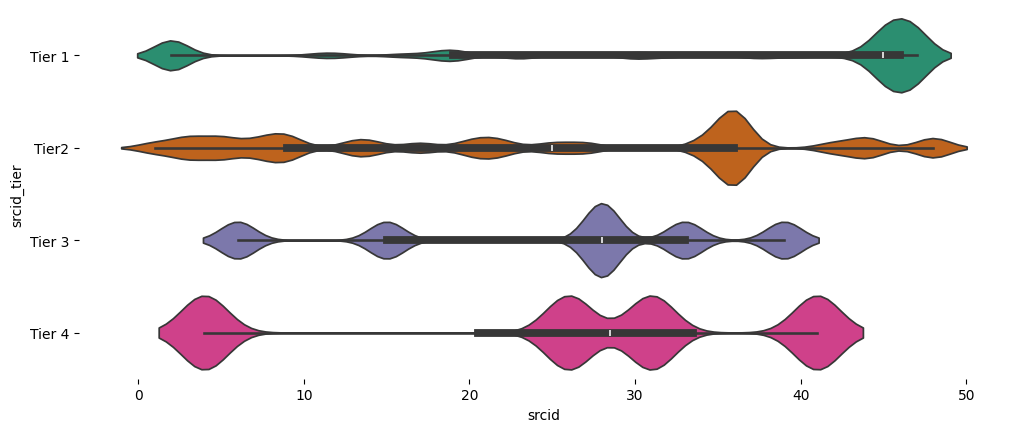

In [ ]:
figsize = (12, 1.2 * len(trans['srcid_tier'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(trans, x='srcid', y='srcid_tier', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

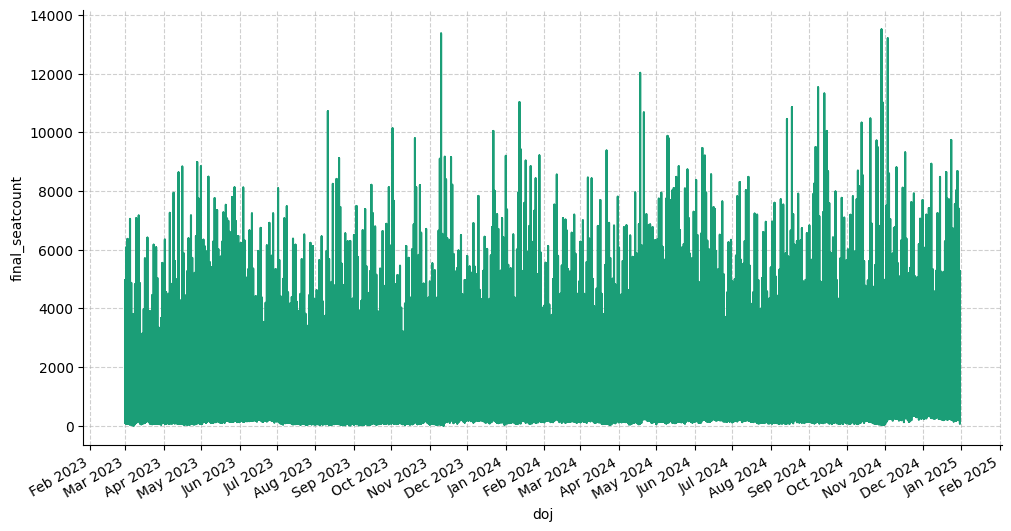

In [ ]:
import matplotlib.dates as mdates

def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['doj']
  ys = series['final_seatcount']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = train_df.sort_values('doj', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)

plt.xlabel('doj')
_ = plt.ylabel('final_seatcount')

ax.grid(True, linestyle='--', alpha=0.6)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
fig.autofmt_xdate()

## Advanced Data Preparation: Engineering Features and Visualizing Patterns

In [38]:
import datetime as dt
from torch_geometric.data import Data, InMemoryDataset, DataLoader
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
import holidays

# Tree-based model imports
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor


# Specify country for holiday calendar; adjust as needed
holiday_country = 'IN'   # Example: 'IN' for India
holiday_calendar = holidays.CountryHoliday(holiday_country)

# ---------------------------
# Feature Engineering
# ---------------------------
# Function to add date features and holiday flags
def add_date_features(df):
    df['day'] = df['doj'].dt.weekday  # 0=Monday
    df['month'] = df['doj'].dt.month  # Not zero-indexed!

    df['is_weekend'] = df['day'].isin([5, 6]).astype(int)
    # Holiday flag using 'python-holidays'
    df['is_holiday'] = df['doj'].dt.date.apply(lambda d: 1 if d in holiday_calendar else 0)
    df['dom'] = df['doj'].dt.day

    # add cyclic(periodic) features
    df['dom_sin'] = np.sin(2 * PI_VAL * df['dom'] / 31)
    df['dom_cos'] = np.cos(2 * PI_VAL * df['dom'] / 31)
    df['month_sin'] = np.sin(2 * PI_VAL * df['month'] / 12)
    df['month_cos'] = np.cos(2 * PI_VAL * df['month'] / 12)
    df['day_sin'] = np.sin(2 * PI_VAL * df['day'] / 7)
    df['day_cos'] = np.cos(2 * PI_VAL * df['day'] / 7)
    #df.drop('dom', axis=1)
    return df

# Apply to train and test
train_df = add_date_features(train_df)
test_df = add_date_features(test_df)

# Precompute route-month average demand from train for merging into both train and test
route_month_avg = (
    train_df.groupby(['srcid', 'destid', 'month'])['final_seatcount']
    .mean()
    .reset_index()
    .rename(columns={'final_seatcount': 'route_month_avg'})
)
train_df = train_df.merge(route_month_avg, on=['srcid', 'destid', 'month'], how='left')

# ---------------------------
# Prepare transaction-derived features for train/validation
# ---------------------------
trans['days_before_departure'] = (trans['doj'] - trans['doi']).dt.days

def compute_cumsum_features(df_rows, trans_df):
    cumsum_list = []
    grp = trans_df.sort_values('doi').groupby(['srcid', 'destid'])
    for idx, row in df_rows.iterrows():
        src = row['srcid']; dest = row['destid']
        pred_date = row['doj'] - pd.Timedelta(days=15)
        try:
            route_trans = grp.get_group((src, dest))
            filt = route_trans[route_trans['doi'] <= pred_date]
            if len(filt) > 0:
                cumsum_seat = filt['cumsum_seatcount'].max()
                cumsum_search = filt['cumsum_searchcount'].max()
            else:
                cumsum_seat = 0.0
                cumsum_search = 0.0
        except KeyError:
            cumsum_seat = 0.0
            cumsum_search = 0.0
        cumsum_list.append((cumsum_seat, cumsum_search))
    arr = np.array(cumsum_list)
    return pd.Series(arr[:, 0], index=df_rows.index), pd.Series(arr[:, 1], index=df_rows.index)

train_cumsum_seat, train_cumsum_search = compute_cumsum_features(train_df[['srcid', 'destid', 'doj']], trans)
train_df['cumsum_seatcount'] = train_cumsum_seat
train_df['cumsum_searchcount'] = train_cumsum_search


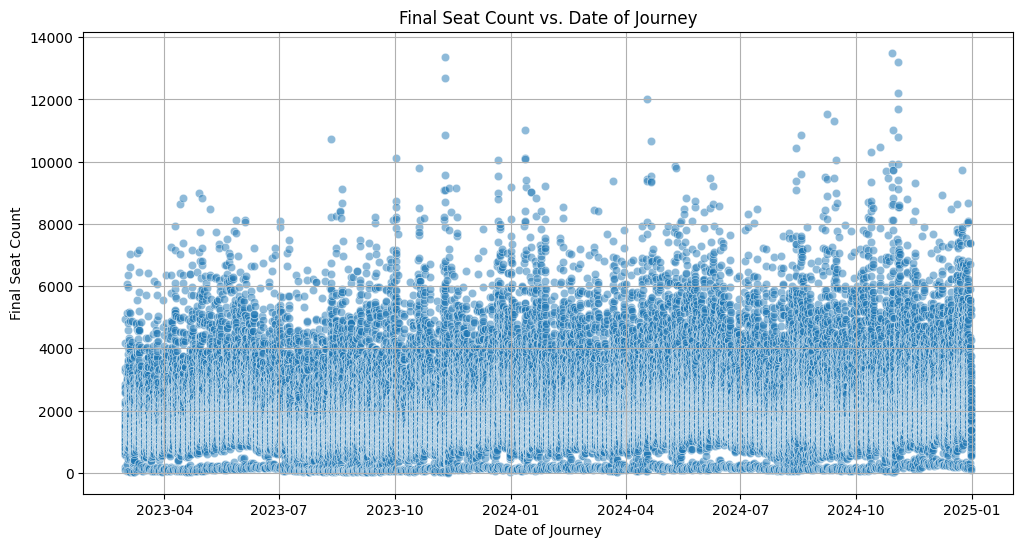

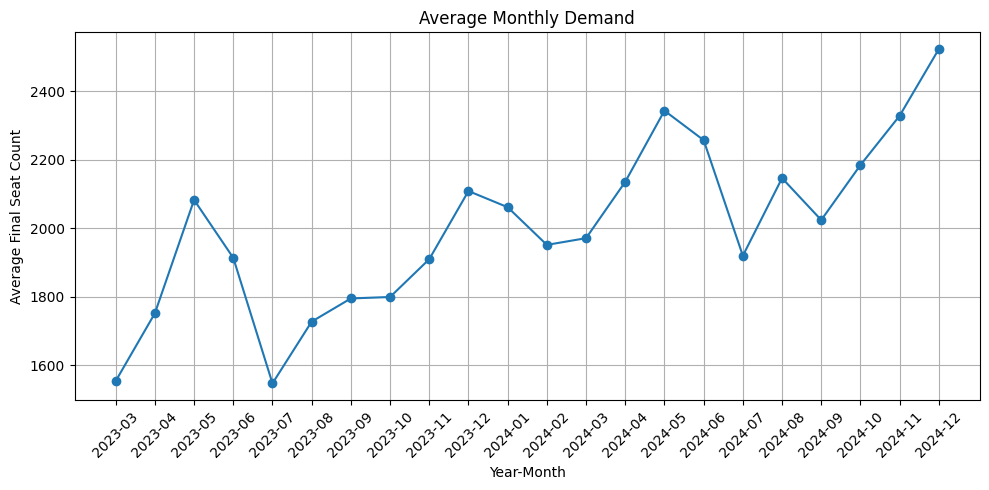

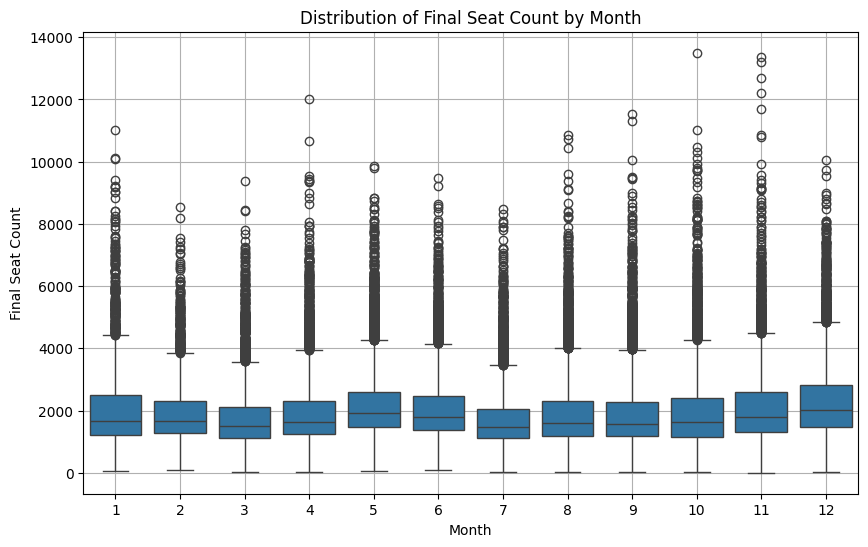

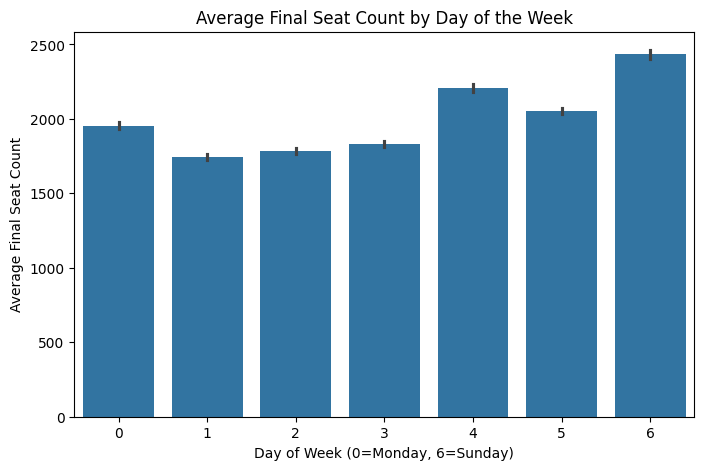

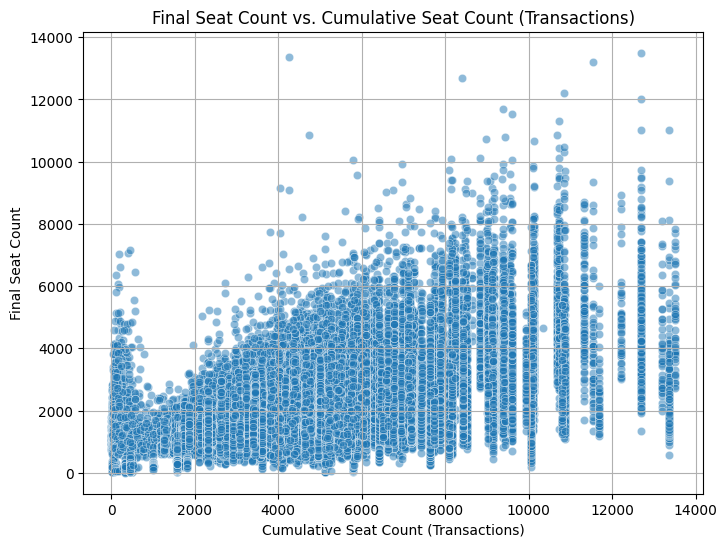

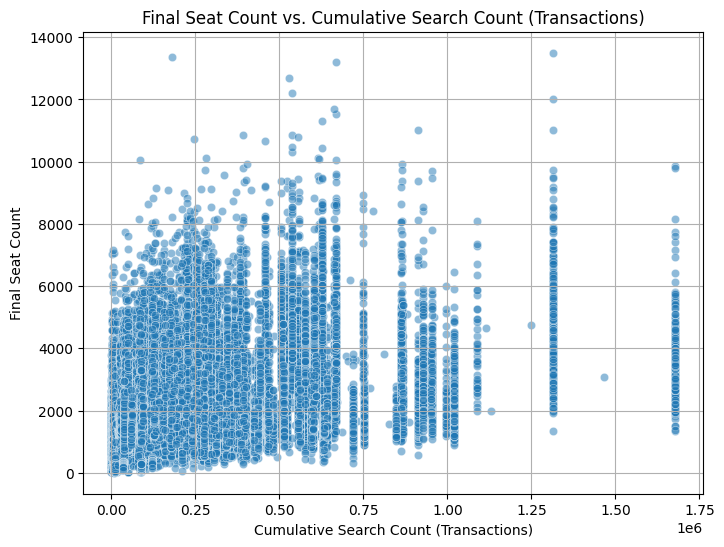

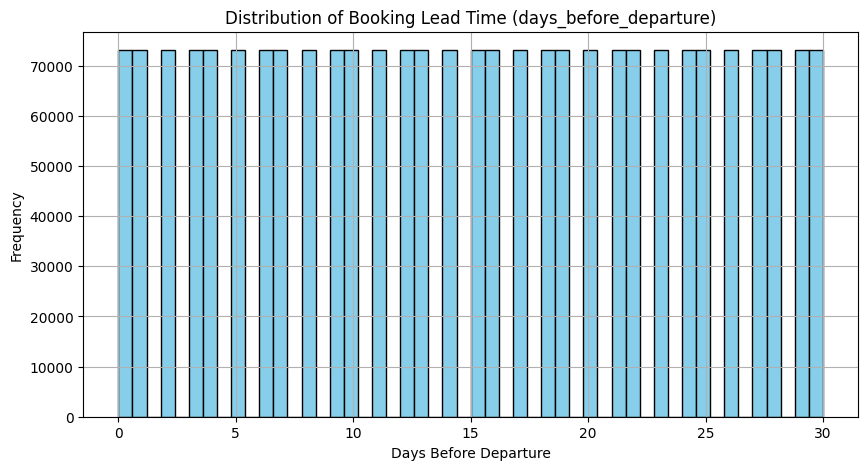

In [ ]:
# -------------------------------------------
# 1. Scatter plot of final_seatcount vs. doj
# -------------------------------------------
plt.figure(figsize=(12, 6))
sns.scatterplot(data=train_df, x='doj', y='final_seatcount', alpha=0.5)
plt.title('Final Seat Count vs. Date of Journey')
plt.xlabel('Date of Journey')
plt.ylabel('Final Seat Count')
plt.grid(True)
plt.show()

print()

# -------------------------------------------
# 1a. Average Monthly Demand Line Plot
# -------------------------------------------
df = train_df.copy()
df['year_month'] = df['doj'].dt.to_period('M')
monthly = df.groupby('year_month')['final_seatcount'].mean().reset_index()

plt.figure(figsize=(10, 5))
plt.plot(monthly['year_month'].astype(str), monthly['final_seatcount'], marker='o')
plt.xticks(rotation=45)
plt.title('Average Monthly Demand')
plt.xlabel('Year-Month')
plt.ylabel('Average Final Seat Count')
plt.tight_layout()
plt.grid(True)
plt.show()

print()

# --------------------------------------------------
# 2. Box plot of final_seatcount across different months
# --------------------------------------------------
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_df, x='month', y='final_seatcount')
plt.title('Distribution of Final Seat Count by Month')
plt.xlabel('Month')
plt.ylabel('Final Seat Count')
plt.grid(True)
plt.show()

print()

# --------------------------------------------------
# 3. Bar plot of avg. final_seatcount across weekdays
# --------------------------------------------------
plt.figure(figsize=(8, 5))
sns.barplot(data=train_df, x='day', y='final_seatcount', estimator=np.mean)
plt.title('Average Final Seat Count by Day of the Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Average Final Seat Count')
plt.show()

print()

# --------------------------------------------------
# 4. Scatter plot: final_seatcount vs. cumsum_seatcount
# --------------------------------------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(data=train_df, x='cumsum_seatcount', y='final_seatcount', alpha=0.5)
plt.title('Final Seat Count vs. Cumulative Seat Count (Transactions)')
plt.xlabel('Cumulative Seat Count (Transactions)')
plt.ylabel('Final Seat Count')
plt.grid(True)
plt.show()

print()

# --------------------------------------------------
# 5. Scatter plot: final_seatcount vs. cumsum_searchcount
# --------------------------------------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(data=train_df, x='cumsum_searchcount', y='final_seatcount', alpha=0.5)
plt.title('Final Seat Count vs. Cumulative Search Count (Transactions)')
plt.xlabel('Cumulative Search Count (Transactions)')
plt.ylabel('Final Seat Count')
plt.grid(True)
plt.show()

print()

# --------------------------------------------------
# 6. Histogram of Booking Lead Time
# --------------------------------------------------
df = trans.copy()
trans['days_before_departure'] = (trans['doj'] - trans['doi']).dt.days

plt.figure(figsize=(10, 5))
plt.hist(trans['days_before_departure'].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Booking Lead Time (days_before_departure)')
plt.xlabel('Days Before Departure')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


## Baseline Models: SARIMAX and Simple Exponential Smoothing

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

# Aggregate train_df to get daily total seat count
daily_demand = train_df.groupby('doj')['final_seatcount'].sum().reset_index()
daily_demand = daily_demand.set_index('doj')

# Split data for baseline evaluation
train_size = len(daily_demand) - 15
train_data, val_data = daily_demand[0:train_size], daily_demand[train_size:]

print("Daily Demand Data:")
display(daily_demand.head())
print("\nValidation Data for Baselines:")
display(val_data.head())

Daily Demand Data:


,final_seatcount
doj,
2023-03-01,137998.0
2023-03-02,149623.0
2023-03-03,198612.0
2023-03-04,186701.0
2023-03-05,205421.0



Validation Data for Baselines:


,final_seatcount
doj,
2024-12-17,197431.0
2024-12-18,204960.0
2024-12-19,224546.0
2024-12-20,303336.0
2024-12-21,304239.0


### SARIMAX Baseline

In [ ]:
# SARIMAX Model
# Parameters (p,d,q) can be tuned, using a simple example here
sarimax_order = (1, 0, 1)

sarimax_preds = []
history = [x for x in train_data['final_seatcount']]

for t in range(len(val_data)):
    model = SARIMAX(history, order=sarimax_order, enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    output = model_fit.predict(start=len(history), end=len(history))
    yhat = output[0]
    sarimax_preds.append(yhat)
    obs = val_data['final_seatcount'].iloc[t]
    history.append(obs)

# Evaluate SARIMAX
rmse_sarimax = np.sqrt(mean_squared_error(val_data['final_seatcount'], sarimax_preds))
print(f'SARIMAX Validation RMSE: {rmse_sarimax:.4f}')

SARIMAX Validation RMSE: 46397.4685


### Simple Exponential Smoothing Baseline

In [ ]:
# Simple Exponential Smoothing Model
# Alpha (smoothing level) can be tuned

ses_preds = []
history = [x for x in train_data['final_seatcount']]

for t in range(len(val_data)):
    model = SimpleExpSmoothing(history)
    model_fit = model.fit()
    yhat = model_fit.predict(start=len(history), end=len(history))
    ses_preds.append(yhat[0])
    obs = val_data['final_seatcount'].iloc[t]
    history.append(obs)

# Evaluate Simple Exponential Smoothing
rmse_ses = np.sqrt(mean_squared_error(val_data['final_seatcount'], ses_preds))
print(f'Simple Exponential Smoothing Validation RMSE: {rmse_ses:.4f}')

Simple Exponential Smoothing Validation RMSE: 46428.2485


## Prepare data for cross-validation


In [28]:
# Fit city_encoder on all unique 'srcid' and 'destid' from both train and test
all_cities = pd.Series(pd.concat([train_df['srcid'], train_df['destid'], test_df['srcid'], test_df['destid']]).unique())
city_encoder = LabelEncoder().fit(all_cities)

# Ensure 'src_n' and 'dest_n' are in train_df for tree models
train_df['src_n'] = city_encoder.transform(train_df['srcid'])
train_df['dest_n'] = city_encoder.transform(train_df['destid'])

FEATURE_COLUMNS = ['day', 'month', 'is_weekend', 'is_holiday', 'cumsum_seatcount', 'cumsum_searchcount', 'route_month_avg', 'src_n', 'dest_n', 'dom', 'dom_sin', 'dom_cos',
                   'month_sin', 'month_cos', 'day_sin', 'day_cos']

# Define the feature matrix X and target vector y
X = train_df[FEATURE_COLUMNS]
y = train_df['final_seatcount']

X.shape, y.shape

((67200, 16), (67200,))

## Implement cross-validation for all models

Implement a cross-validation loop for each of the specified models (GNN, RandomForest, XGBoost, LightGBM, CatBoost) on the entire training dataset (`train_df`). Inside the loop, split the data into training and validation folds, train the model on the training fold, evaluate on the validation fold using RMSE, and store the RMSE scores for each fold. After the loop, calculate and store the average RMSE for each model.


### Tree-based models

In [10]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

# Define the number of splits for cross-validation
n_splits = 5
cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Initialize lists to store RMSE scores for each model
rf_rmse_scores = []
xgb_rmse_scores = []
lgb_rmse_scores = []
cat_rmse_scores = []

# Start the cross-validation loop for tree-based models
print("Starting Cross-Validation for Tree-Based Models...\n")
for fold, (train_index, val_index) in enumerate(cv.split(X, y)):
    print(f"\n--- Fold {fold+1}/{n_splits} ---\n")

    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    # Random Forest
    print("Training Random Forest...")
    rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf.fit(X_train_fold, y_train_fold)
    pred_rf = rf.predict(X_val_fold)
    rmse_rf = np.sqrt(mean_squared_error(y_val_fold, pred_rf))
    rf_rmse_scores.append(rmse_rf)
    print(f"Random Forest Fold {fold+1} RMSE: {rmse_rf:.4f}")

    # XGBoost
    print("Training XGBoost...")
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42, n_jobs=-1)
    xgb_model.fit(X_train_fold, y_train_fold, eval_set=[(X_val_fold, y_val_fold)], verbose=False)
    pred_xgb = xgb_model.predict(X_val_fold)
    rmse_xgb = np.sqrt(mean_squared_error(y_val_fold, pred_xgb))
    xgb_rmse_scores.append(rmse_xgb)
    print(f"XGBoost Fold {fold+1} RMSE: {rmse_xgb:.4f}")

    # LightGBM
    print("Training LightGBM...")
    lgb_train = lgb.Dataset(X_train_fold, label=y_train_fold)
    lgb_val = lgb.Dataset(X_val_fold, label=y_val_fold, reference=lgb_train)
    params = {'objective': 'regression', 'metric': 'rmse', 'verbose': -1}
    lgb_model = lgb.train(params, lgb_train, num_boost_round=1000, valid_sets=[lgb_train, lgb_val], callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=-1)])
    pred_lgb = lgb_model.predict(X_val_fold, num_iteration=lgb_model.best_iteration)
    rmse_lgb = np.sqrt(mean_squared_error(y_val_fold, pred_lgb))
    lgb_rmse_scores.append(rmse_lgb)
    print(f"LightGBM Fold {fold+1} RMSE: {rmse_lgb:.4f}")

    # CatBoost
    print("Training CatBoost...")
    cat_model = CatBoostRegressor(iterations=1000, eval_metric='RMSE', random_seed=42, verbose=False)
    cat_model.fit(X_train_fold, y_train_fold, eval_set=(X_val_fold, y_val_fold), early_stopping_rounds=50, verbose=False)
    pred_cat = cat_model.predict(X_val_fold)
    rmse_cat = np.sqrt(mean_squared_error(y_val_fold, pred_cat))
    cat_rmse_scores.append(rmse_cat)
    print(f"CatBoost Fold {fold+1} RMSE: {rmse_cat:.4f}")

print("\nCross-Validation for Tree-Based Models Complete.")

# Calculate and store the average RMSE for each tree-based model
avg_rmse_rf = np.mean(rf_rmse_scores)
avg_rmse_xgb = np.mean(xgb_rmse_scores)
avg_rmse_lgb = np.mean(lgb_rmse_scores)
avg_rmse_cat = np.mean(cat_rmse_scores)

Starting Cross-Validation for Tree-Based Models...


--- Fold 1/5 ---

Training Random Forest...
Random Forest Fold 1 RMSE: 564.5199
Training XGBoost...
XGBoost Fold 1 RMSE: 499.8136
Training LightGBM...
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 331.849	valid_1's rmse: 430.51
LightGBM Fold 1 RMSE: 430.5104
Training CatBoost...
CatBoost Fold 1 RMSE: 490.1657

--- Fold 2/5 ---

Training Random Forest...
Random Forest Fold 2 RMSE: 578.8405
Training XGBoost...
XGBoost Fold 2 RMSE: 520.8200
Training LightGBM...
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 332.217	valid_1's rmse: 445.033
LightGBM Fold 2 RMSE: 445.0328
Training CatBoost...
CatBoost Fold 2 RMSE: 505.9335

--- Fold 3/5 ---

Training Random Forest...
Random Forest Fold 3 RMSE: 578.8218
Training XGBoost...
XGBoost Fold 3 RMSE: 530.1987
Training LightGBM.

### GNN-model

In [39]:
len(city_encoder.classes_)

48

In [44]:
# delete unwanted cache-files
!rm -rf data/processed/gnn_fold_*

In [45]:
# Preparing the Network
num_nodes = len(city_encoder.classes_)

edges = pd.concat([train_df[['srcid', 'destid']], test_df[['srcid', 'destid']]]).drop_duplicates()
edges['src_n'] = city_encoder.transform(edges['srcid'])
edges['dest_n'] = city_encoder.transform(edges['destid'])
edge_index_arr = np.vstack([np.concatenate([edges['src_n'].values, edges['dest_n'].values]),
                             np.concatenate([edges['dest_n'].values, edges['src_n'].values])])
global_edge_index = torch.tensor(edge_index_arr, dtype=torch.long)


# GNN Model Definition
class GNNForecast(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_nodes):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels * num_nodes, 1)
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = torch.relu(self.conv1(x, edge_index))
        x = torch.relu(self.conv2(x, edge_index))
        batch_size = data.num_graphs
        x = x.view(batch_size, num_nodes * x.size(-1))
        out = self.lin(x)
        return out.view(-1)

class BusDataset(InMemoryDataset):
    def __init__(self, root, df_rows, mode='train', transform=None, pre_transform=None):
        self.df = df_rows.reset_index(drop=True)
        self.mode = mode
        super().__init__(root, transform, pre_transform)
        # Modified to load with weights_only=False
        if os.path.exists(self.processed_paths[0]):
             self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)
        else:
            self.process()
            self.data, self.slices = torch.load(self.processed_paths[0], weights_only=False)


    @property
    def raw_file_names(self): return []

    @property
    def processed_file_names(self): return [f'bus_data_{self.mode}.pt']

    def process(self):
        data_list = []
        for idx, row in self.df.iterrows():
            x_all = torch.zeros((num_nodes, len(FEATURE_COLUMNS)), dtype=torch.float)
            feat = [row.get(col, 0.0) for col in FEATURE_COLUMNS]
            src_idx = city_encoder.transform([row['srcid']])[0]
            dest_idx = city_encoder.transform([row['destid']])[0]
            x_all[src_idx] = torch.tensor(feat, dtype=torch.float)
            x_all[dest_idx] = torch.tensor(feat, dtype=torch.float)
            data = Data(x=x_all, edge_index=global_edge_index)
            if self.mode in ['train', 'val']:
                data.y = torch.tensor([row['final_seatcount']], dtype=torch.float)
            data.idx = torch.tensor([idx], dtype=torch.long)
            data_list.append(data)
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])


# Initialize list to store GNN RMSE scores
gnn_rmse_scores = []

# GNN Cross-Validation Loop
print("Starting Cross-Validation for GNN Model...\n")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Re-define X and y correctly
FEATURE_COLUMNS = ['day', 'month', 'is_weekend', 'is_holiday', 'cumsum_seatcount', 'cumsum_searchcount', 'route_month_avg',
    'srcid', 'destid', 'dom', 'dom_sin', 'dom_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos'                                   # Use original srcid/destid for GNN, not encoded
]
X = train_df[FEATURE_COLUMNS]
y = train_df['final_seatcount']

n_splits = 5
cv = KFold(n_splits=n_splits, shuffle=True, random_state=42)
best_GNN_RMSE = float('inf')

for fold, (train_index, val_index) in enumerate(cv.split(X, y)):
    print(f"\n--- GNN Fold {fold+1}/{n_splits} ---\n")

    # Get the actual data rows for the current fold using the original train_df index
    train_rows_fold = train_df.iloc[train_index].copy()
    val_rows_fold = train_df.iloc[val_index].copy()

    fold_root = f'data/processed/gnn_fold_{fold}'
    os.makedirs(fold_root, exist_ok=True)

    train_dataset_fold = BusDataset(fold_root, train_rows_fold, mode='train')
    val_dataset_fold = BusDataset(fold_root, val_rows_fold, mode='val')
    train_loader_fold = DataLoader(train_dataset_fold, batch_size=32, shuffle=True)
    val_loader_fold = DataLoader(val_dataset_fold, batch_size=32, shuffle=False)

    # Instantiate and train the GNN model for the current fold
    model = GNNForecast(in_channels=len(FEATURE_COLUMNS), hidden_channels=64, num_nodes=num_nodes).to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=5e-4)
    loss_fn = torch.nn.MSELoss()

    # Training loop with early stopping for GNN
    num_epochs = 1000
    patience = 10
    best_val_rmse_fold = float('inf')
    epochs_no_improve = 0

    for epoch in range(1, num_epochs + 1):
        model.train()
        total_loss = 0.0
        for batch in train_loader_fold:
            batch = batch.to(device)
            optimizer.zero_grad()
            pred = model(batch)
            loss = loss_fn(pred, batch.y.view(-1).to(device))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader_fold)

        model.eval()
        val_preds_fold, val_trues_fold = [], []
        with torch.no_grad():
            for batch in val_loader_fold:
                batch = batch.to(device)
                pred = model(batch)
                val_preds_fold.append(pred.cpu().numpy())
                val_trues_fold.append(batch.y.view(-1).cpu().numpy())
        val_preds_fold = np.concatenate(val_preds_fold)
        val_trues_fold = np.concatenate(val_trues_fold)
        rmse_gnn_fold = np.sqrt(mean_squared_error(val_trues_fold, val_preds_fold))

        if rmse_gnn_fold < best_val_rmse_fold:
            best_val_rmse_fold = rmse_gnn_fold
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                # print(f"Early stopping GNN Fold {fold+1} at epoch {epoch}.") # Optional: print early stopping
                break

    if best_val_rmse_fold < best_GNN_RMSE:
        best_GNN_RMSE = best_val_rmse_fold
        # also, save the best-model state
        torch.save(model.state_dict(), 'best_gnn_model.pth')

    gnn_rmse_scores.append(best_val_rmse_fold)
    print(f"GNN Fold {fold+1} Best Val RMSE: {best_val_rmse_fold:.4f}")

print("\nCross-Validation for GNN Model Complete.")

# Calculate and store the average RMSE for GNN
avg_rmse_gnn = np.mean(gnn_rmse_scores)

Starting Cross-Validation for GNN Model...


--- GNN Fold 1/5 ---

GNN Fold 1 Best Val RMSE: 748.3078

--- GNN Fold 2/5 ---

GNN Fold 2 Best Val RMSE: 767.1187

--- GNN Fold 3/5 ---

GNN Fold 3 Best Val RMSE: 767.3544

--- GNN Fold 4/5 ---

GNN Fold 4 Best Val RMSE: 766.2707

--- GNN Fold 5/5 ---

GNN Fold 5 Best Val RMSE: 737.7166

Cross-Validation for GNN Model Complete.


In [ ]:
import networkx as nx
import plotly.graph_objects as go
from torch_geometric.utils import to_dense_adj

# Convert tensor to numpy adjacency matrix
adj_tensor = to_dense_adj(global_edge_index)[0]
adj = adj_tensor.cpu().numpy()

# Create NetworkX graph
G = nx.from_numpy_array(adj, create_using=nx.DiGraph)

# Get node positions using a layout algorithm
pos = nx.spring_layout(G)

# Extract edge coordinates for Plotly
edge_x = []
edge_y = []
for src, dst in G.edges():
    x0, y0 = pos[src]
    x1, y1 = pos[dst]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

# Edge trace
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=1, color='gray'),
    hoverinfo='none',
    mode='lines')

# Node coordinates and hover text
node_x = []
node_y = []
for node in G.nodes():
    x_coord, y_coord = pos[node]
    node_x.append(x_coord)
    node_y.append(y_coord)

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=False,
        color='skyblue',
        size=10,
        line_width=2))

# Create figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title='Route Graph',
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20,l=5,r=5,t=40),
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False)))

fig.show()

A Snapshot of the above Figure is saved as `GNN-viz.png`, in the `results` folder.

## Comparing the Cross-Validation Scores



Compare the average `RMSE-scores` of all models to find the best performing one and print the result.



In [46]:
# Combine and print all average RMSEs
print(f"Overall Average RMSE (Cross-Validation):")
print(f"  Random Forest: {avg_rmse_rf:.4f}")
print(f"  XGBoost:       {avg_rmse_xgb:.4f}")
print(f"  LightGBM:      {avg_rmse_lgb:.4f}")
print(f"  CatBoost:      {avg_rmse_cat:.4f}")
print(f"  GNN:           {avg_rmse_gnn:.4f}")

Overall Average RMSE (Cross-Validation):
  Random Forest: 567.5230
  XGBoost:       514.1179
  LightGBM:      443.0590
  CatBoost:      501.1670
  GNN:           757.3536


## Hyperparameter Tuning using Optuna

In [ ]:
import optuna
from tqdm.notebook import tqdm
import logging
import time
from IPython.display import clear_output
from sklearn.model_selection import cross_val_score

# Silence LightGBM logging
logging.getLogger('lightgbm').setLevel(logging.ERROR)
# Silence Optuna's internal INFO logs (we'll use tqdm instead)
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Define the CV strategy.
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Objective for LightGBM.
def objective_lgb(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 150),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 100),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", -1, 15),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
        "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 1.0)
    }
    model = lgb.LGBMRegressor(**params, n_jobs=-1, verbose=-1)
    scores = cross_val_score(model, X, y, cv=cv, scoring="neg_root_mean_squared_error")
    # Note: cross_val_score with scoring="neg_root_mean_squared_error" returns negative values, so we take the negative of the mean to get the average RMSE.
    rmse = -np.mean(scores)
    return rmse

# Optimize LightGBM.
study = optuna.create_study(direction="minimize")
n_trials = 65
for _ in tqdm(range(n_trials), desc="Optuna Trials"):
    study.optimize(objective_lgb, n_trials=1)

# Post-optimization pause + clear
time.sleep(0.1)
clear_output(wait=True)

# Final output
print("Best parameters:", study.best_params)
print("Best CV RMSE:   ", study.best_value)

Best parameters: {'learning_rate': 0.0997043524908911, 'num_leaves': 133, 'min_data_in_leaf': 38, 'n_estimators': 888, 'max_depth': 13, 'subsample': 0.9625557930570342, 'colsample_bytree': 0.7093176143589404, 'reg_alpha': 0.1552707651848497, 'reg_lambda': 0.1649625785275688, 'min_split_gain': 0.12955124076752442}
Best CV RMSE:    406.19324013718995


## Predictions on test set

Apply the same feature engineering steps used for the training data to the test dataset (`test_df`) to ensure consistency before making predictions, using the `best_model`.

In [30]:
lgb_best_params = {'learning_rate': 0.0997043524908911, 'num_leaves': 133, 'min_data_in_leaf': 38, 'n_estimators': 888, 'max_depth': 13, 'subsample': 0.9625557930570342, 'colsample_bytree': 0.7093176143589404, 'reg_alpha': 0.1552707651848497, 'reg_lambda': 0.1649625785275688, 'min_split_gain': 0.12955124076752442}
best_model = lgb.LGBMRegressor(**lgb_best_params, random_seed=42, verbose=-1)
best_model.fit(X, y)

test_df = test_df.merge(route_month_avg, on=['srcid', 'destid', 'month'], how='left')
assert test_df.isnull().sum().sum() == 0, "Null values found in test_df after merge!"
test_cumsum_seat, test_cumsum_search = compute_cumsum_features(test_df[['srcid', 'destid', 'doj']], trans)
test_df['cumsum_seatcount'] = test_cumsum_seat
test_df['cumsum_searchcount'] = test_cumsum_search
test_df['src_n'] = city_encoder.transform(test_df['srcid'])
test_df['dest_n'] = city_encoder.transform(test_df['destid'])

FEATURE_COLUMNS = ['day', 'month', 'is_weekend', 'is_holiday', 'cumsum_seatcount', 'cumsum_searchcount', 'route_month_avg', 'src_n', 'dest_n', 'dom', 'dom_sin', 'dom_cos',
                   'month_sin', 'month_cos', 'day_sin', 'day_cos']
X_test = test_df[FEATURE_COLUMNS]

display(X_test.head())

,day,month,is_weekend,is_holiday,cumsum_seatcount,cumsum_searchcount,route_month_avg,src_n,dest_n,dom,dom_sin,dom_cos,month_sin,month_cos,day_sin,day_cos
0,1,2,0,0,9118.0,345512.0,4245.310345,45,44,11,0.790776,-0.612106,0.866025,0.500000,0.781831,0.623490
1,0,1,0,0,2965.0,60940.0,1360.483871,16,22,20,-0.790776,-0.612106,0.500000,0.866025,0.000000,1.000000
2,2,1,0,0,7190.0,598780.0,1474.354839,1,13,8,0.998717,-0.050649,0.500000,0.866025,0.974928,-0.222521
3,2,1,0,0,4385.0,295970.0,1601.290323,7,46,8,0.998717,-0.050649,0.500000,0.866025,0.974928,-0.222521
4,2,1,0,0,12219.0,750117.0,5130.096774,8,45,8,0.998717,-0.050649,0.500000,0.866025,0.974928,-0.222521


# Generate the Submission File

In [31]:
test_preds = best_model.predict(X_test)

# Ensure predictions are non-negative
test_preds[test_preds < 0] = 0

submission = test_df[['route_key']].copy().reset_index(drop=True)
submission['final_seatcount'] = test_preds.round()

# Save the submission file
submission.to_csv('submission.csv', index=False)

print("Submission file saved.\n")
display(submission.head())

Submission file saved.



,route_key,final_seatcount
0,2025-02-11_46_45,3828.0
1,2025-01-20_17_23,1526.0
2,2025-01-08_02_14,1358.0
3,2025-01-08_08_47,1102.0
4,2025-01-08_09_46,4018.0


# Feature Importances

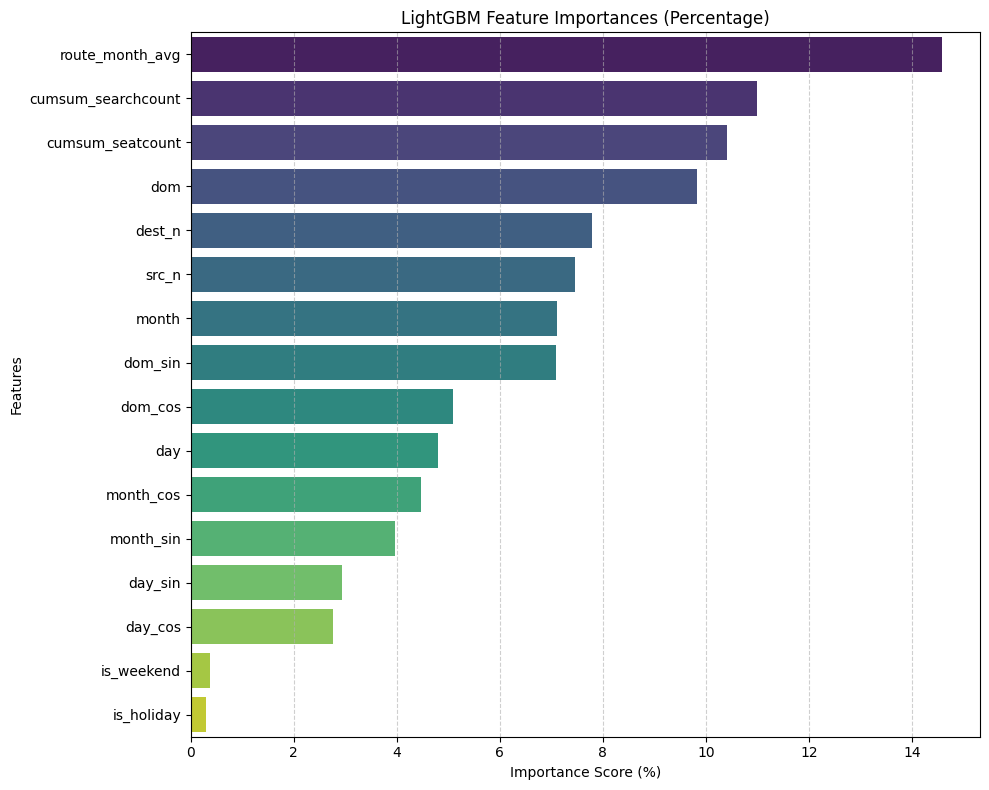

In [33]:
feature_importances = best_model.feature_importances_
features = X.columns

# Create a DataFrame to visualize feature importances
df_feat_imp = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Calculate percentages
df_feat_imp['Importance_Percent'] = (df_feat_imp['Importance'] / df_feat_imp['Importance'].sum()) * 100

# Plot the feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance_Percent', y='Feature', hue='Feature', data=df_feat_imp, palette="viridis", legend=False)
plt.title("LightGBM Feature Importances (Percentage)")
plt.xlabel("Importance Score (%)")
plt.ylabel("Features")
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

# Save the `best_model` for Further use

In [34]:
# save 'best_model' as .pkl
import joblib
joblib.dump(best_model, 'best_model.pkl')

['best_model.pkl']

# Comprehensive Report of Findings

This report summarizes the key findings and steps undertaken in the bus demand forecasting project, integrating insights from data analysis, model training, and evaluation.

### Data Loading & Exploratory Analysis Findings

*   Three datasets were loaded: `train_df` (67200 rows, 4 columns), `trans` (2266100 rows, 11 columns), and `test_df` (5900 rows, 4 columns).
*   Initial inspection showed no missing values in `train_df`.
*   The `train_df` contains `doj`, `srcid`, `destid`, and `final_seatcount`. `trans` contains detailed transaction information including `doj`, `doi`, `srcid`, `destid`, region and tier information, cumulative seat/search counts, and days before departure. `test_df` contains `route_key`, `doj`, `srcid`, and `destid`.
*   Exploratory plots revealed the distribution of `srcid`, `destid`, and `final_seatcount` in `train_df`.
*   Outlier detection using the IQR method on `train_df` identified 4141 outliers in the `final_seatcount` column, while `srcid` and `destid` had no outliers.
*   Visualizations of the `trans` data showed the distribution of `srcid`, `destid`, `cumsum_seatcount`, and `cumsum_searchcount`, as well as the distribution across `srcid_tier` and `destid_tier`.
*   Time series plots of `train_df` showed the trend of `srcid`, `destid`, and `final_seatcount` over time. A specific plot highlighted the time series of `final_seatcount` with monthly markers.
*   Further visualizations in the "Advanced Data Preparation" section provided insights into:
    *   The relationship between `final_seatcount` and `doj` (scatter plot).
    *   The average monthly demand (`final_seatcount`).
    *   The distribution of `final_seatcount` by month (box plot).
    *   The average `final_seatcount` by day of the week (bar plot).
    *   The relationship between `final_seatcount` and `cumsum_seatcount` (scatter plot).
    *   The relationship between `final_seatcount` and `cumsum_searchcount` (scatter plot).
    *   The distribution of booking lead time (`days_before_departure`) from the `trans` data (histogram).

### Feature Engineering Findings

*   Date-related features (`day`, `month`, `is_weekend`, `is_holiday`, `dom`, `dom_sin`, `dom_cos`, `month_sin`, `month_cos`, `day_sin`, `day_cos`) were successfully engineered for both `train_df` and `test_df`.
*   A `route_month_avg` feature, representing the average `final_seatcount` for a given source-destination route and month, was computed from `train_df` and merged into both `train_df` and `test_df`.
*   Cumulative transaction features (`cumsum_seatcount`, `cumsum_searchcount`) were computed for both `train_df` and `test_df` based on the `trans` data, considering transactions up to 15 days before the departure date.
*   A `LabelEncoder` was fitted on the combined unique `srcid` and `destid` values from both train and test sets to create encoded numerical features (`src_n`, `dest_n`) for use in the tree-based models.

### Baseline Model Evaluation

*   Two baseline time series models were evaluated on daily aggregated `final_seatcount`:
    *   SARIMAX (with order (1,0,1)) achieved a Validation RMSE of **46397.4685**.
    *   Simple Exponential Smoothing achieved a Validation RMSE of **46428.2485**.
*   These high RMSE values indicate that models incorporating more granular features (like route and transaction data) are necessary for accurate forecasting.

### Model Training and Cross-Validation

*   Cross-validation with 5 splits (`KFold`, `shuffle=True`, `random_state=42`) was implemented for five models: Random Forest, XGBoost, LightGBM, CatBoost, and a GNN.
*   For the tree-based models (Random Forest, XGBoost, LightGBM, CatBoost), 16 features were used: `day`, `month`, `is_weekend`, `is_holiday`, `cumsum_seatcount`, `cumsum_searchcount`, `route_month_avg`, `src_n`, `dest_n`, `dom`, `dom_sin`, `dom_cos`, `month_sin`, `month_cos`, `day_sin`, `day_cos`.
*   For the GNN model, a different set of 12 features was used, excluding the encoded city IDs (`src_n`, `dest_n`) as the graph structure implicitly handles the city relationships.
*   The average cross-validation RMSE scores were computed for each model:
    *   Random Forest: **567.5230**
    *   XGBoost: **514.1179**
    *   LightGBM: **443.0590** (<-)
    *   CatBoost: **501.1670**
    *   GNN: **757.3536**
*   Based on the lowest average cross-validation RMSE, the **LightGBM** model (average RMSE: **443.0590**) was identified as the best-performing model among those evaluated.

### Hyperparameter Tuning

*   Hyperparameter tuning was performed for the LightGBM model using Optuna with 65 trials and 5-fold cross-validation.
*   The best parameters found by Optuna were: `{'learning_rate': 0.0997, 'num_leaves': 133, 'min_data_in_leaf': 38, 'n_estimators': 888, 'max_depth': 13, 'subsample': 0.9626, 'colsample_bytree': 0.7093, 'reg_alpha': 0.1553, 'reg_lambda': 0.1650, 'min_split_gain': 0.1296}`.
*   The best cross-validation RMSE achieved during Optuna tuning was `406.1932`.

### Prediction and Submission

*   The LightGBM model with the best hyperparameters found by Optuna was retrained on the entire training dataset (`X`, `y`).
*   The same feature engineering steps applied to the training data were successfully applied to the test dataset (`test_df`) to create `X_test` with the consistent 16 features.
*   Predictions were generated on the prepared `X_test` using the retrained LightGBM model.
*   Predicted seat counts were ensured to be non-negative by setting any negative predictions to 0.
*   The final predictions were rounded to the nearest whole number.
*   A submission file (`submission.csv`) was successfully generated containing the `route_key` and the predicted `final_seatcount`.

### Feature Importance

*   Feature importance analysis for the final LightGBM model showed that `route_month_avg`, `cumsum_searchcount`, and `cumsum_seatcount` were the most important features for predicting `final_seatcount`.

### Save the Best-Model

* The `best_model` was saved as a `.pkl`-file, for future purposes.

### Insights or Next Steps

*   The LightGBM model, particularly after hyperparameter tuning, demonstrated strong performance compared to other models and baselines.
*   The cumulative transaction features and the route-month average feature proved to be highly informative for demand forecasting.
*   While the GNN model's initial performance was not as strong as the tree-based models, further exploration of GNN architectures, feature representations, and training strategies could potentially improve its results. The current GNN implementation might benefit from incorporating more spatio-temporal dynamics or richer node/edge features.
*   Further analysis of the outliers identified in the `final_seatcount` could be beneficial to understand if they represent valid high-demand events or data errors. Depending on the nature of the outliers, different handling strategies (e.g., capping, transformation) could be explored.
*   Investigating potential interactions between features or exploring ensemble methods combining the strengths of different models (e.g., LightGBM and a refined GNN) could lead to further improvements in prediction accuracy.